Run the following cell if on Google Colab to load Python modules

In [1]:
!wget https://raw.githubusercontent.com/karencfisher/forward-forward/main/models.py
!wget https://raw.githubusercontent.com/karencfisher/forward-forward/main/layers.py
!wget https://raw.githubusercontent.com/karencfisher/forward-forward/main/utils.py

--2023-02-21 02:46:22--  https://raw.githubusercontent.com/karencfisher/forward-forward/main/models.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2961 (2.9K) [text/plain]
Saving to: ‘models.py’

models.py           100%[===================>]   2.89K  --.-KB/s    in 0s      

2023-02-21 02:46:23 (46.0 MB/s) - ‘models.py’ saved [2961/2961]

--2023-02-21 02:46:23--  https://raw.githubusercontent.com/karencfisher/forward-forward/main/layers.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1613 (1.6K) [text/plain]
Saving to: ‘la

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score, confusion_matrix

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Mean
from tensorflow.data import Dataset
import tensorflow as tf

import utils
from layers import FFDense
from models import FFNetwork

4422102/4422102 [==============================] - 0s 0us/step
60000 training examples
10000 testing examples


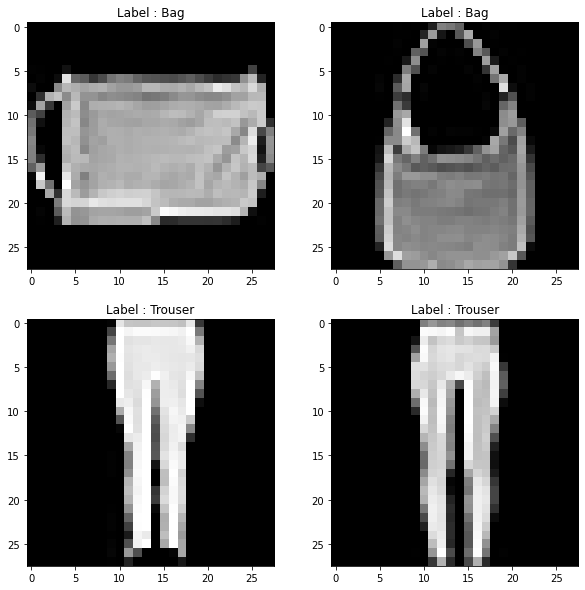

In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.astype(float) / 255
x_test = x_test.astype(float) / 255
y_train = y_train.astype(int)
y_test = y_test.astype(int)

print(f'{x_train.shape[0]} training examples\n{x_test.shape[0]} testing examples')

train_dataset = Dataset.from_tensor_slices((x_train, y_train))
test_dataset = Dataset.from_tensor_slices((x_test, y_test))

train_dataset = train_dataset.batch(60000)
test_dataset = test_dataset.batch(10000)

utils.show_samples(x_train, y_train, 4, class_names)

## Build and train the Forward-Foward model!

In [4]:
model = FFNetwork([784, 500, 500])

model.compile(
    optimizer=Adam(learning_rate=0.03),
    loss="mse",
    jit_compile=True,
    metrics=[Mean()],
)

In [5]:
history = model.fit(train_dataset, epochs=250, verbose=1)

Epoch 1/250
Training layer 1 now : 
Training layer 2 now : 
Training layer 1 now : 
Training layer 2 now : 
1/1 [==============================] - 80s 80s/step - FinalLoss: 0.7223
Epoch 2/250
1/1 [==============================] - 6s 6s/step - FinalLoss: 0.7069
Epoch 3/250
1/1 [==============================] - 6s 6s/step - FinalLoss: 0.6926
Epoch 4/250
1/1 [==============================] - 6s 6s/step - FinalLoss: 0.6783
Epoch 5/250
1/1 [==============================] - 6s 6s/step - FinalLoss: 0.6653
Epoch 6/250
1/1 [==============================] - 6s 6s/step - FinalLoss: 0.6535
Epoch 7/250
1/1 [==============================] - 6s 6s/step - FinalLoss: 0.6432
Epoch 8/250
1/1 [==============================] - 6s 6s/step - FinalLoss: 0.6337
Epoch 9/250
1/1 [==============================] - 6s 6s/step - FinalLoss: 0.6252
Epoch 10/250
1/1 [==============================] - 6s 6s/step - FinalLoss: 0.6176
Epoch 11/250
1/1 [==============================] - 6s 6s/step - FinalLoss: 0.610

## Model Evaluation

Test Accuracy score : 88.35%


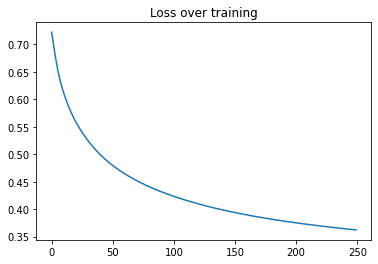

In [6]:
preds = model.predict(tf.convert_to_tensor(x_test))
preds = preds.reshape((preds.shape[0], preds.shape[1]))
results = accuracy_score(preds, y_test)
print(f"Test Accuracy score : {results*100}%")

plt.plot(range(len(history.history["FinalLoss"])), history.history["FinalLoss"])
plt.title("Loss over training")
plt.show()

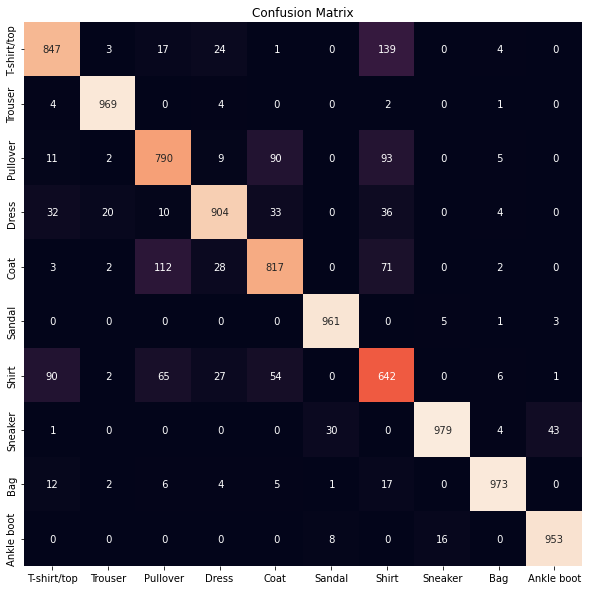

In [7]:
plt.figure(figsize=(10, 10))
cm = confusion_matrix(preds, y_test)
sns.heatmap(cm, 
            annot=True, 
            fmt='2d', 
            cbar=False, 
            cmap='rocket', 
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.show()

### Looking at the errors

We can just make a dataframe of all the mismatches, the predicted and actual labels, and sort them

In [8]:
y_hat = np.squeeze(preds)
misses_df = pd.DataFrame(columns=['Predicted', 'Actual'])
misses_df['Predicted'] = y_hat
misses_df['Actual'] = y_test
cond = misses_df['Predicted'] != misses_df['Actual']
misses_df = misses_df[cond]
misses_df = misses_df.sort_values(by=['Predicted', 'Actual'])
misses_df.reset_index(inplace=True)
misses_df = misses_df.rename(columns = {'index':'Example'})

misses_df

,Example,Predicted,Actual
0,9071,0,1
1,9450,0,1
2,9485,0,1
3,382,0,2
4,732,0,2
...,...,...,...
1160,5520,9,7
1161,6085,9,7
1162,6300,9,7
1163,6701,9,7


Group by the prediected and actual labels and find the top ten mistakes

In [9]:
misses_df.groupby(['Predicted', 'Actual']).size().sort_values(ascending=False)[:10]

Predicted  Actual
0          6         139
4          2         112
2          6          93
6          0          90
2          4          90
4          6          71
6          2          65
           4          54
7          9          43
3          6          36
dtype: int64

We can compare the predicted and actual labels for sample of the misclassified images. We may note the ambiguities?

In [10]:
def compare(predicted, actual):
  cond = (misses_df['Predicted'] == predicted) & (misses_df['Actual'] == actual)
  examples = misses_df[cond]['Example']

  samps = random.sample(list(examples), 4)
  imgs = []
  for samp in samps:
    imgs.append((x_test[samp], y_hat[samp], y_test[samp]))

  plt.figure(figsize=(10, 10))
  for idx, item in enumerate(imgs):
      image, predlabel, label = item
      plt.subplot(2, 2, idx + 1)
      plt.imshow(image, cmap="gray")
      plt.title(f"Predicted: {class_names[predlabel]} Actual: {class_names[label]}")
  plt.show()


Since mislabeling 6 (Shirt) as 0 (t-shirt/top) is the most common mistake (152 errors), we can look at a few examples. The ambiguities may be apparent.

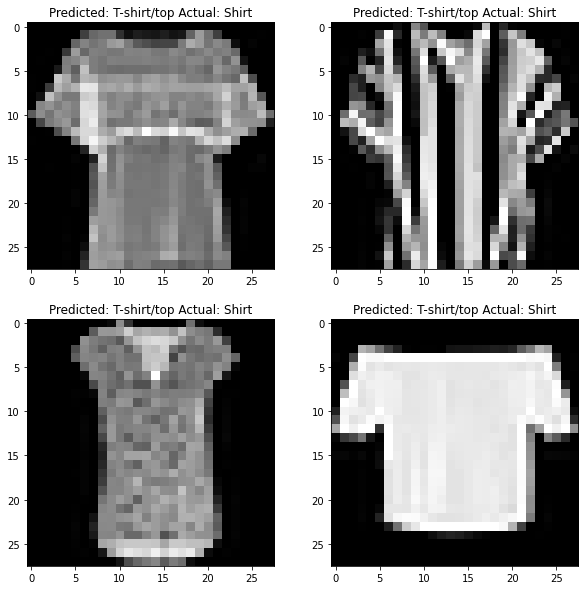

In [11]:
compare(0, 6)

And vice versa

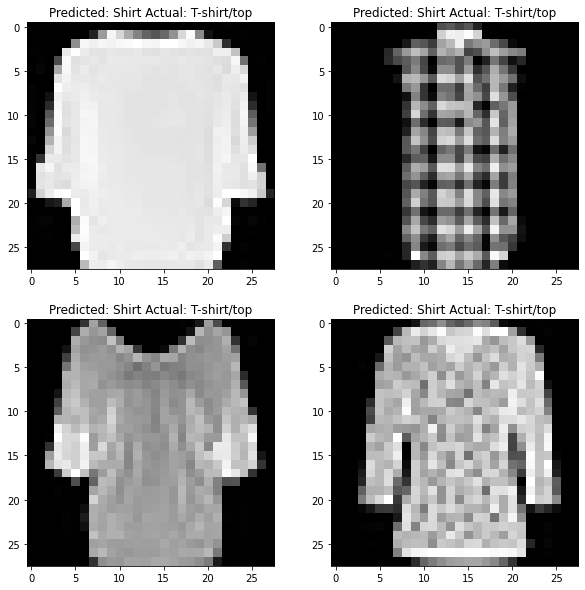

In [12]:
compare(6, 0)

Mistaking 9 (sneaker) for 7 (ankle boot) is the least common error in the top ten (52 errors). One can get perceive how the model can be confused.

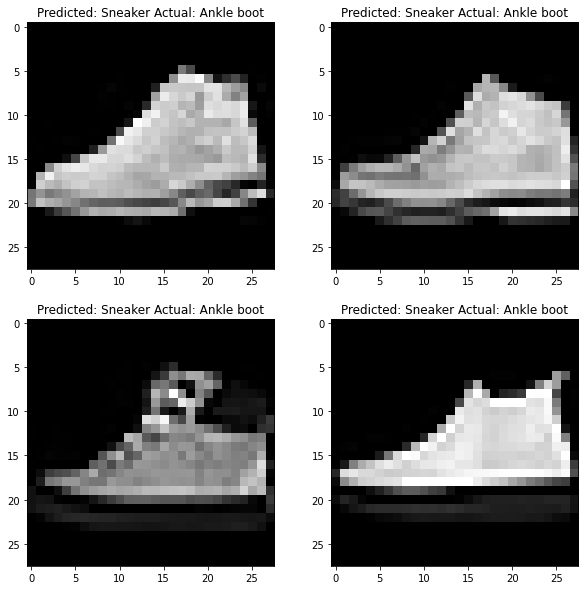

In [13]:
compare(7, 9)

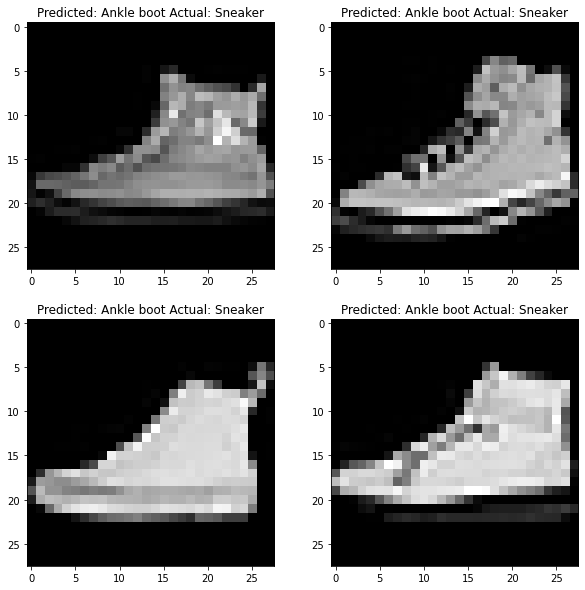

In [14]:
compare(9, 7)